In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy
import time

import psutil
from distributed.utils import format_bytes

#only for python3
import importlib
reload=importlib.reload

In [2]:
from cov_3X2 import *
from fisher import *
from PCA_shear import *

In [3]:
import PCA_shear
reload(PCA_shear)
from PCA_shear import *

In [4]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [5]:
import lsst_utils
reload(lsst_utils)
from lsst_utils import *

In [6]:
fig_home='./figures/'
fig_format='pdf'

In [7]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=12,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [8]:

dask.config.set(scheduler='synchronous')  # overwrite default with single-threaded scheduler

In [9]:
def cosmo_w0_wa(cosmo=None,w0=-1,wa=0):
    attrs=['H0','Om0', 'Ode0','Tcmb0', 'Neff', 'm_nu', 'Ob0']
    args={}
    args['w0']=w0
    args['wa']=wa
    for a in attrs:
        args[a]=getattr(cosmo,a)
    cosmo_w=astropy.cosmology.w0waCDM(**args)
    return cosmo_w
cosmo_w0_wa(cosmo=cosmo)

w0waCDM(H0=67.7 km / (Mpc s), Om0=0.307, Ode0=0.691, w0=-1, wa=0, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [10]:
def cosmo_h_set(cosmo=None,cosmo_params={}):
    if cosmo_params['wa']!=0:
        cosmo=cosmo_w0_wa(cosmo=cosmo,w0=cosmo_params['w'],wa=cosmo_params['wa'])
    cosmo2=cosmo.clone(H0=cosmo_params['h']*100,
                        Om0=cosmo_params['Om'],
                       Ob0=cosmo_params['Omb'],
#                        Odm0=cosmo_params['Omd'],
#                        Ok0=cosmo_params['Omk'],
#                        w=cosmo_params['w'],
                       m_nu=[0,0,cosmo_params['mnu']]*units.eV
                    )

In [11]:
def get_x_var(x0=None,dx_max=0.01,do_log=False,Nx=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    if do_log:
        x0=np.absolute(x0)
        x_vars=x0**Dx
        if x0==1:
            x_vars=(2.**Dx)/2. # 1**x=1
        if x0==0:
            x_vars=np.logspace(-3,-2,Nx)
        x_vars*=np.sign(cosmo_fid[p])
        x_grad=np.gradient(np.log(x_vars))
    else:
        x_vars=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        if x0==0:
            x_vars=Dx-1
        x_grad=np.gradient(x_vars)
    return x_vars,x_grad

In [12]:
def fish_cosmo_model(p='As',Nx=2,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False,z_bins_kwargs={}):
    x0=cosmo_fid[p]

    models={}
    covs={}
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    print(p,x_vars)
    for i in np.arange(Nx):
        cosmo_t=cosmo_fid.copy()

        cosmo_t[p]=x_vars[i]

        if p=='s8':
            s80=cosmo_fid['s8']
            cosmo_t['As']*=(cosmo_t['s8']/s80)**2
            kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
            kappa_class.Ang_PS.PS.pk=None
            x_vars[i]=kappa_class.Ang_PS.PS.s8
#                 print(x_vars[p][i],s80,cosmo_t['s8'])
        cosmo_h2=cosmo_h_set(cosmo=cosmo,cosmo_params=cosmo_t)
        cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t,cosmo_h=cosmo_h2,stack_corr_indxs=z_bins_kwargs['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad

In [13]:
def pz_update(z_bins={},bin_indx=None,z_indx=None,pz_new=None):
    z_bins[bin_indx]['pz'][z_indx]=pz_new
    z_bins=zbin_pz_norm(zs_bins=z_bins,bin_indx=bin_indx,zs=z_bins[bin_indx]['z'],p_zs=z_bins[bin_indx]['pz'],ns=z_bins[bin_indx]['ns'])
    return z_bins

In [14]:
def set_zbin_bias0(zs_bins={},bias=0):
    bias0=np.copy(zs_bins['zp_bias'])
    bias0=bias*(1+zs_bins['zp'])
    return bias0

def set_zbin_bias(zs_bins={},bias=0,bin_id=0):
    bias0=np.copy(zs_bins['zp_bias'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    bias0[np.where(idx==bin_id)]=bias
    return bias0

def set_zbin_sigma(zs_bins={},zsigma_frac=1,bin_id=0):
    zp_sigma=np.copy(zs_bins['zp_sigma'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    zp_sigma[np.where(idx==bin_id)]=zp_sigma[np.where(idx==bin_id)]*zsigma_frac
    return zp_sigma
    
def fish_z_model(p='pz_b_s_1',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    z_bins_kwargs=z_bins_kwargs0.copy()
    zs_bins=z_bins_kwargs['zs_bins']
    zl_bins=z_bins_kwargs['zl_bins']
    zlD_bins=z_bins_kwargs['zlD_bins']
    if 'pz_b' in p:
        x0=0
    elif 'nz' in p:
        pp=p.split('_')
        bin_id=np.int(pp[-2])
        z_id=np.int(pp[-1])
        print(bin_id,z_id)
        if 'nz_s' in p:
            x0=zs_bins[bin_id]['pz'][z_id]
        elif 'nz_l' in p:
            x0=zl_bins[bin_id]['pz'][z_id]
            
        if x0<1.e-5:
            x0=0
    else:
        x0=1
        
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        zs_bins_i=zs_bins.copy()
        zl_bins_i=zl_bins.copy()
        if 'pz_B' in p:
            bias=set_zbin_bias0(zs_bins=zs_bins,bias=x_vars[i])
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        elif 'pz_b_s' in p:
            bin_id=np.int(p[-1])
            bias=set_zbin_bias(zs_bins=zs_bins,bias=x_vars[i],bin_id=bin_id)
#             zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(z_bias=bias, nbins=z_bins_kwargs['ns_bins'],ns0=z_bins_kwargs['nsource'],z_sigma=z_bins_kwargs['z_source_sigma'],
                                            **z_bins_kwargs)
        elif 'pz_b_l' in p:
            bin_id=np.int(p[-1])#-zs_bins['n_bins']
            bias=set_zbin_bias(zs_bins=zl_bins,bias=x_vars[i],bin_id=bin_id)

            zl_bins_i=lsst_source_tomo_bins(z_bias=bias,nbins=z_bins_kwargs['n_lens_bins'],ns0=z_bins_kwargs['nlens'],z_sigma=z_bins_kwargs['z_lens_sigma'],
                                            **z_bins_kwargs)
        elif 'nz_s' in p:
            zs_bins_i=pz_update(z_bins=zs_bins_i,bin_indx=bin_id,z_indx=z_id,pz_new=x_vars[i])
        elif 'nz_l' in p:
            zl_bins_i=pz_update(z_bins=zl_bins_i,bin_indx=bin_id,z_indx=z_id,pz_new=x_vars[i])

        elif 'sig' in p:
            bin_id=np.int(p[-1])
            zp_sigma=set_zbin_sigma(zs_bins=zs_bins,zsigma_frac=x_vars[i],bin_id=0)
            zs_bins_kwargs['z_sigma']=zp_sigma
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
                
        zl_bins_comb=combine_zbins(z_bins1=zl_bins_i,z_bins2=zlD_bins)
        zl_bins_comb=combine_zbins(z_bins1=zs_bins_i,z_bins2=zl_bins_comb)
        kappa_class.update_zbins(z_bins=zs_bins_i,probe='shear')
        kappa_class.update_zbins(z_bins=zl_bins_comb,probe='galaxy')
        cl0G=kappa_class.cl_tomo(stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    kappa_class.update_zbins(z_bins=zs_bins,probe='shear')
    return models,covs,x_vars,x_grad

In [15]:
def fish_galaxy_model(p='g_b_l_11',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    
    z_bins_kwargs=z_bins_kwargs0.copy()
    zs_bins=z_bins_kwargs['zs_bins']
    z_bins=kappa_class.z_bins['galaxy']
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    p_n='b'+p[-2]
    if 'b' in p:
        bin_indx=np.int(p[-1])
        if 'l' in p:
            bin_indx+=zs_bins['n_bins']
        x0=kappa_class.z_bins['galaxy'][bin_indx][p_n]
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        z_bins_t=z_bins.copy()
        if 'b' in p:
            z_bins_t[bin_indx][p_n]=x_vars[i]
        
        kappa_class.update_zbins(z_bins=z_bins_t,probe='galaxy')
        cl0G=kappa_class.cl_tomo(stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
        z_bins_t[bin_indx][p[:-1]]=x0
    kappa_class.update_zbins(z_bins=z_bins,probe='galaxy')
    return models,covs,x_vars,x_grad    

In [16]:
def fish_baryon_model(p='Q1',Nx=2,dx_max=0.01,kappa_class=None,clS=None,cl0=None,do_cov=False,do_log=False,
                      z_bins_kwargs0={},NmarQ=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    if 'Q' in p:
        Q_indx=np.int(p[-1])
        x0=0
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    cov_F=1.#/np.median(np.diag(clS['cov']))
    print(p,clS['cov'].shape,np.linalg.det(clS['cov']*cov_F))
    
    PCS=PCA_shear(kappa_class=kappa_class,NmarQ=NmarQ,clS=clS)
    
    for i in np.arange(Nx):
        Q0=[0]*NmarQ
        Q0[Q_indx]=x_vars[i]
        
        cl_t=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=Q0)
        models[i]=np.zeros_like(cl0) #this is needed to keep everything in right shape. Baryon stuff is only for shear right now. 
        models[i][:len(cl_t)]+=cl_t #['cl_b']
        models[i][len(cl_t):]+=cl0[len(cl_t):]
        print(models[i].shape,PCS.COV.shape)
        covs[i]=PCS.COV
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad    

# PCS=PCA_shear(kappa_class=kappa_class,NmarQ=3)
# cl_t1=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[-10,-10,-10])
# cl_t0=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[0,0,0])

In [17]:
def fisher_calc(cosmo_params=['As'],z_params=[],galaxy_params=[],baryon_params=[],Nx=2,dx_max=0.01,do_log=False,
                kappa_class=None,do_cov=False,baryon_PCA_nQ=2,clS=None,
               cov_3X2_kwargs={},z_bins_kwargs={},ell_bin_kwargs={},cl0=None,priors=None):
    t1=time.time()
    if kappa_class is None:
        zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
        l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
        kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
        
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov
    cl0G=kappa_class.cl_tomo()
    
    if clS is None:
        kappa_class.do_cov=True #need covariance to start things.
        cl0G=kappa_class.cl_tomo()
    
        clS=cl0G['stack'].compute()
#     cl_t=client.submit(cl0G['stack'])
    cl0=clS['cl_b']
    t2=time.time()
    print(cl0G['cov'],t2-t1)
    cl_shear=delayed(kappa_class.stack_dat)(dat={'cov':cl0G['cov'],'cl_b':cl0G['cl_b'],'est':'cl_b'},corrs=[corr_ll])
    cl_shear=cl_shear.compute()
#     cl_t=client.submit(cl0G['stack'])
    t3=time.time()
    print('shear',t3-t1)
    
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    cosmo_h=kappa_class.Ang_PS.PS.cosmo_h.clone()
    cov=clS['cov']
    kappa_class.Ang_PS.reset()

    ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
    params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
    params_all=np.append(params_all,baryon_params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    x_grads={}
    for p in cosmo_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_cosmo_model(p=p,Nx=Nx,dx_max=dx_max,do_log=do_log,
                                                     kappa_class=kappa_class,do_cov=do_cov,z_bins_kwargs=z_bins_kwargs)
    for p in z_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_z_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    
    for p in galaxy_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_galaxy_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    
    for p in baryon_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_baryon_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,clS=cl_shear,cl0=cl0,
                                                 do_cov=do_cov,NmarQ=baryon_PCA_nQ)
    
    for p in params_all:
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grads[p]
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grads[p]
#             print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params_all:
        i2=0
        for p2 in params_all:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            
            if do_cov:
#                 print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p_inv']=np.copy(cov_p_inv)
    out['params_all']=params_all
    if priors is not None:
        out=fish_apply_priors(fish=out,priors=priors)
#         i2=0
#         for p1 in params_all:
#             cov_p_inv[i2,i2]+=1./priors[p1]**2
#             i2+=1
    try:
        out['cov_p']=np.linalg.inv(cov_p_inv)
        out['error']=np.sqrt(np.diag(out['cov_p']))
    except Exception as err:
        print(err)

    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['cov_inv']=cov_inv
    out['model']=models
    out['x_vars']=x_vars
    
    kappa_class.do_cov=do_cov0
    return out

In [18]:
def fish_apply_priors(priors=None,fish=[]):
#     ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
#     params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
#     params_all=np.append(params_all,baryon_params)
    params_all=fish['params_all']
    ndim=len(params_all)
    
    cov_p_inv=np.copy(fish['cov_p_inv'])
    fish['prior']={}
    priors2={}
    i2=0
    for p1 in params_all:
        priors2[p1]=priors[p1]
        cov_p_inv[i2,i2]+=1./priors[p1]**2
        i2+=1
    fish['prior']['cov_p_inv']=cov_p_inv
    fish['prior']['prior']=priors2
    try:
        fish['prior']['cov_p']=np.linalg.inv(cov_p_inv)
        fish['prior']['error']=np.sqrt(np.diag(fish['prior']['cov_p']))
    except Exception as err:
        print(err)
    return fish

In [19]:
k='corrs3_zmin0_barynQ2_pkfclass_pk_SSVFalse'

In [20]:
def get_cl_ells(lmax_cl=1000,lmin_cl=2,Nl_bins=40):
    l0=np.arange(lmin_cl,lmax_cl)

    lmin_cl_Bins=lmin_cl+10
    lmax_cl_Bins=lmax_cl-10
    l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
    

    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    return l0,l_bins,l


In [21]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
# corrs=[corr_ll] #
corrs=[corr_ggl,corr_gg,corr_ll]

In [22]:
def combine_zbins(z_bins1={},z_bins2={}):
    z_bins3=z_bins1.copy()
    j=0
    for i in np.arange(z_bins1['n_bins'],z_bins1['n_bins']+z_bins2['n_bins']):
#         print(i,z_bins2.keys())
        z_bins3[i]=z_bins2[j]
        j+=1
    z_bins3['n_bins']+=z_bins2['n_bins']
    for i in np.arange(z_bins3['n_bins']):
        z_bins3[i]['b1']=1
    return z_bins3

In [23]:
z_min_iter=[0,0.3]
z_max_iter=[3,2]
corrs_iter=[[corr_ll],[corr_ll,corr_ggl,corr_gg]]
pk_iter=['class_pk','baryon_pk']
SSV_iter=[False,True]
nz_iter=[26,20,50]
nbins_iter=[3,1,5]
l_max_iter=[1000,2000,5000]
bary_nQ_iter=[0,2,1,3,5]

cosmo_params=np.atleast_1d(['As','Om','w','wa'])
pz_iter=[[],'pzb']

In [24]:

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

window_lmax=30
nside=32

sigma_gamma=0.26
area=15000
f_sky=area*d2r**2/4/np.pi

In [25]:
zmin=0.3
zmax=2
power_spectra_kwargs={'pk_func':'baryon_pk'}

nbins=2
n_lens_bins=2
n_lensD_bins=2

In [26]:
def get_z_bins(zmin,zmax,ns_bins,n_lens_bins,n_lensD_bins,nsource=nz_iter[0],nlens=10,nDlens=5,use_window=use_window,
               nside=nside,z_source_sigma=0.05,z_lens_sigma=0.01,area_overlap=0.2,f_sky=0.3,**kwargs):
    
    zs_bins=lsst_source_tomo_bins(zmin=zmin,zmax=zmax,nside=nside,ns0=nsource,nbins=ns_bins,f_sky=f_sky,
                                  z_sigma_power=1,z_sigma=z_source_sigma,ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,)
    
    zl_bins=lsst_source_tomo_bins(zmin=zmin,zmax=zmax,ns0=nlens,nbins=n_lens_bins,nside=nside,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,
                        z_sigma=z_lens_sigma)
    
    zlD_bins=lsst_source_tomo_bins(ns0=nDlens,nbins=n_lensD_bins,nside=nside,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,
                        z_sigma=0.0001,mask_start_pix=np.int32(hp.nside2npix(nside)*f_sky*(1-area_overlap)))
    
    return zs_bins,zl_bins,zlD_bins

In [27]:
def init_fish(z_min=z_min_iter[0],z_max=z_max_iter[0],corrs=corrs_iter[0],SSV=SSV_iter[0],
              pk_func=pk_iter[0],nz=nz_iter[0],n_source_bins=nbins_iter[0],f_sky=0.3,
              l_max=l_max_iter[0],l_min=2,Nl_bins=40,Win=None,store_win=True,
             n_lens_bins=3,n_lensD_bins=0,nlens0=10):
    
    power_spectra_kwargs2=power_spectra_kwargs.copy()
    power_spectra_kwargs2['pk_func']=pk_func
    
    cov_3X2_kwargs={'do_cov':do_cov,'bin_cl':bin_cl, #'l':l0,'l_bins':l_bins,
            'SSV_cov':SSV,'tidal_SSV_cov':SSV,'do_xi':False,'use_window':use_window,'window_lmax':window_lmax,
            'f_sky':f_sky,'sigma_gamma':sigma_gamma,'corrs':corrs,'store_win':store_win,'Win':Win,
            'do_sample_variance':do_sample_variance,'power_spectra_kwargs':power_spectra_kwargs2,'f_sky':f_sky,
            'bin_xi':bin_xi}
    
    z_bins_kwargs={'zmin':z_min,'zmax':z_max,'nsource':nz,'ns_bins':nbins,'nside':nside,'n_lens_bins':n_lens_bins,'n_lensD_bins':n_lens_bins,
                    'use_window':use_window,'nlens':nlens0,'nDlens':nlens0/2.,'area_overlap':0.2, 'f_sky':f_sky,'z_lens_sigma':0.01,
                   'z_source_sigma':0.05}
    ell_bin_kwargs={'lmax_cl':l_max,'lmin_cl':l_min,'Nl_bins':Nl_bins}
    
    
    zs_bins,zl_bins,zlD_bins=get_z_bins(**z_bins_kwargs)
    
    z_bins_kwargs['zs_bins']=zs_bins
    z_bins_kwargs['zl_bins']=zl_bins
    z_bins_kwargs['zlD_bins']=zlD_bins
    
    zl_bins_comb=combine_zbins(z_bins1=zl_bins,z_bins2=zlD_bins)
    zl_bins_comb=combine_zbins(z_bins1=zs_bins,z_bins2=zl_bins_comb)

    ii_lens=np.arange(n_source_bins,n_source_bins+n_lens_bins+n_lensD_bins)
    ii_s=np.arange(n_source_bins)
    z_bins_kwargs['gg_indxs']=[(i,j) for i in ii_s for j in ii_lens]+[(i,i) for i in ii_lens]
#     for i in np.arange(zl_bins_comb['n_bins']):
#         zl_bins_comb[i]['b1']=1
        
    cov_3X2_kwargs['zg_bins']=zl_bins_comb    
    
    l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
    print(l0.max(),zl_bins_comb['n_bins'])
    kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
    
#     if not use_window:
#         for kk in kappa_class.corr_indxs.keys():
#             indxs=kappa_class.corr_indxs[kk]

#             for (i,j) in indxs:
#                 if i<(n_source_bins+n_lens_bins) and j<(n_source_bins+n_lens_bins):
#                     continue
#                 if i>(n_source_bins+n_lens_bins) and j>(n_source_bins+n_lens_bins):
#                     continue
                    
#                 kappa_class.f_sky[kk][(i,j)]=z_bins_kwargs['f_sky']*z_bins_kwargs['area_overlap']
#                 kappa_class.f_sky[kk[::-1]][(j,i)]=z_bins_kwargs['f_sky']*z_bins_kwargs['area_overlap']
    
    z_bins_kwargs['corr_indxs']=kappa_class.corr_indxs.copy()
    z_bins_kwargs['corr_indxs'][('galaxy','galaxy')]=z_bins_kwargs['gg_indxs']
    return kappa_class,z_bins_kwargs

In [28]:
#setup parameters
l0,l_bins,l=get_cl_ells()
lb=0.5*(l_bins[1:]+l_bins[:-1])

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [44]:
# corrs=[corr_ll] #
corrs=[corr_ggl,corr_gg,corr_ll]

In [45]:
WIN=None
store_win=False

In [46]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

291.63 MB


In [47]:
fname='temp/win_D_{ns}{nl}{nlD}.pkl'.format(ns=nbins,nl=n_lens_bins,nlD=n_lensD_bins)
if store_win:
    try:
        with open(fname,'rb') as of:
            WIN=pickle.load(of)
    except:
        print('window not found. Will compute')

In [68]:
kappa_class,z_bins_kwargs=init_fish(n_source_bins=nbins,n_lens_bins=n_lens_bins,n_lensD_bins=n_lensD_bins,corrs=corrs,
                                          Win=WIN,store_win=store_win)
%time cl0G=kappa_class.cl_tomo(corrs=corrs,stack_corr_indxs=z_bins_kwargs['corr_indxs'])
lb=0.5*(l_bins[1:]+l_bins[:-1])
# cl0=cl0G['stack'].compute()

ns0:  25.674672523983695
ns0:  9.874874047686037
ns0:  4.439288369880776
999 6


./cov_utils.py:68: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 9.46 s


In [69]:
n_lens_bins

2

In [70]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

2.26 GB


In [71]:
cl_L=None

In [72]:
kappa_class.z_bins['shear']['n_bins']

2

In [73]:
kappa_class.Win

{}

In [74]:
if cl_L is None:
    %time cl_L=cl0G['stack'].compute()
#     with open(fname_cl,'wb') as of:
#         pickle.dump(cl_L,of)

CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 24s


In [75]:
cl_L['cl_b'].shape

(1053,)

In [76]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

2.24 GB


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


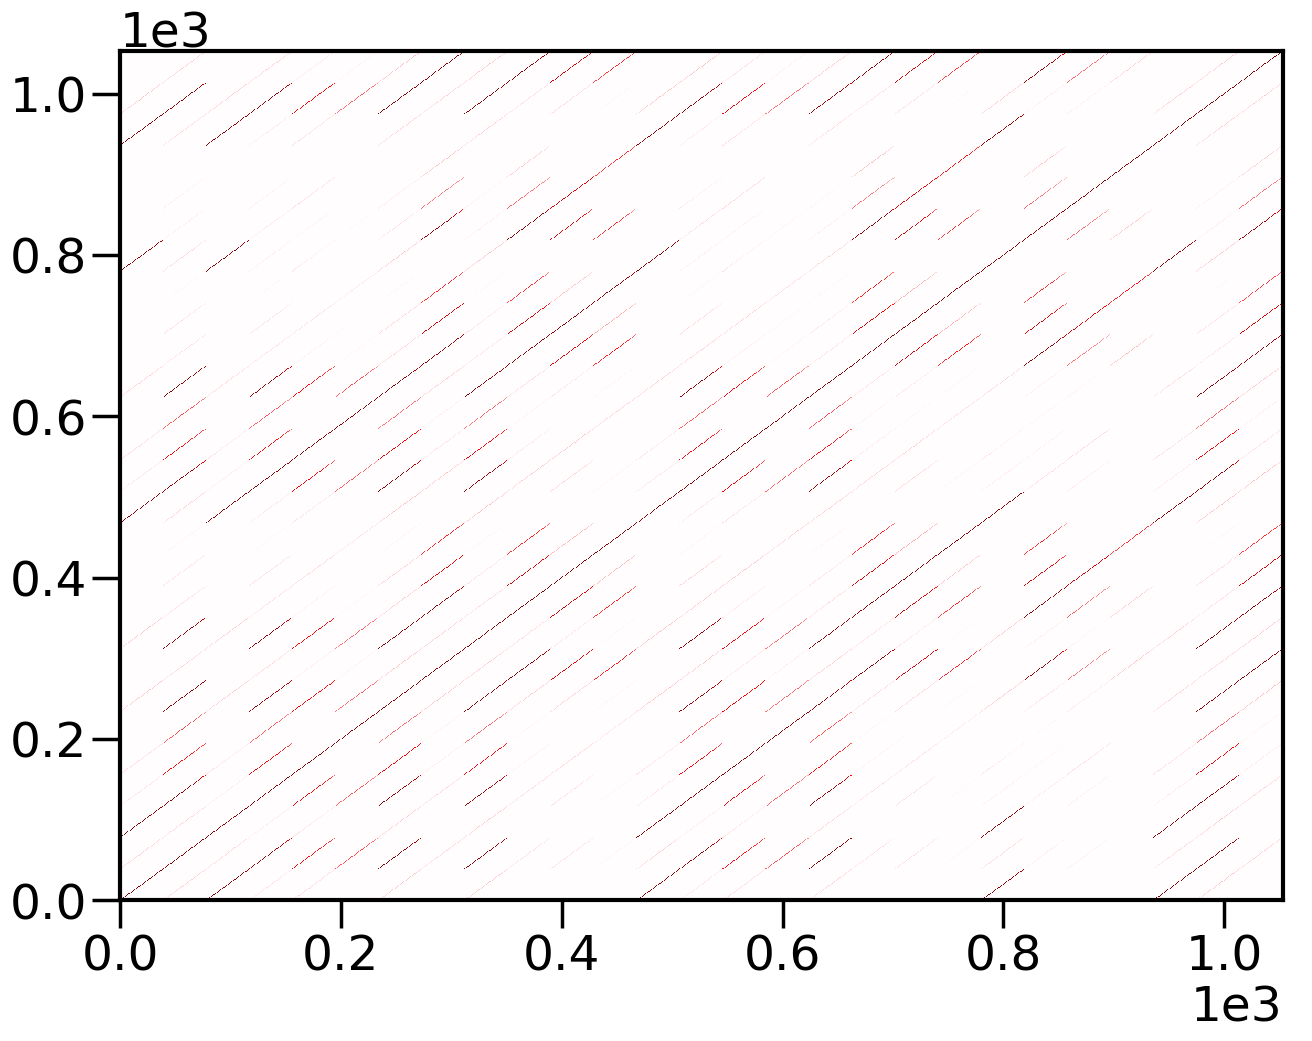

In [77]:
cc=kappa_class.cov_utils
corr_shear=cc.corr_matrix(cl_L['cov'])
pcolor(corr_shear,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


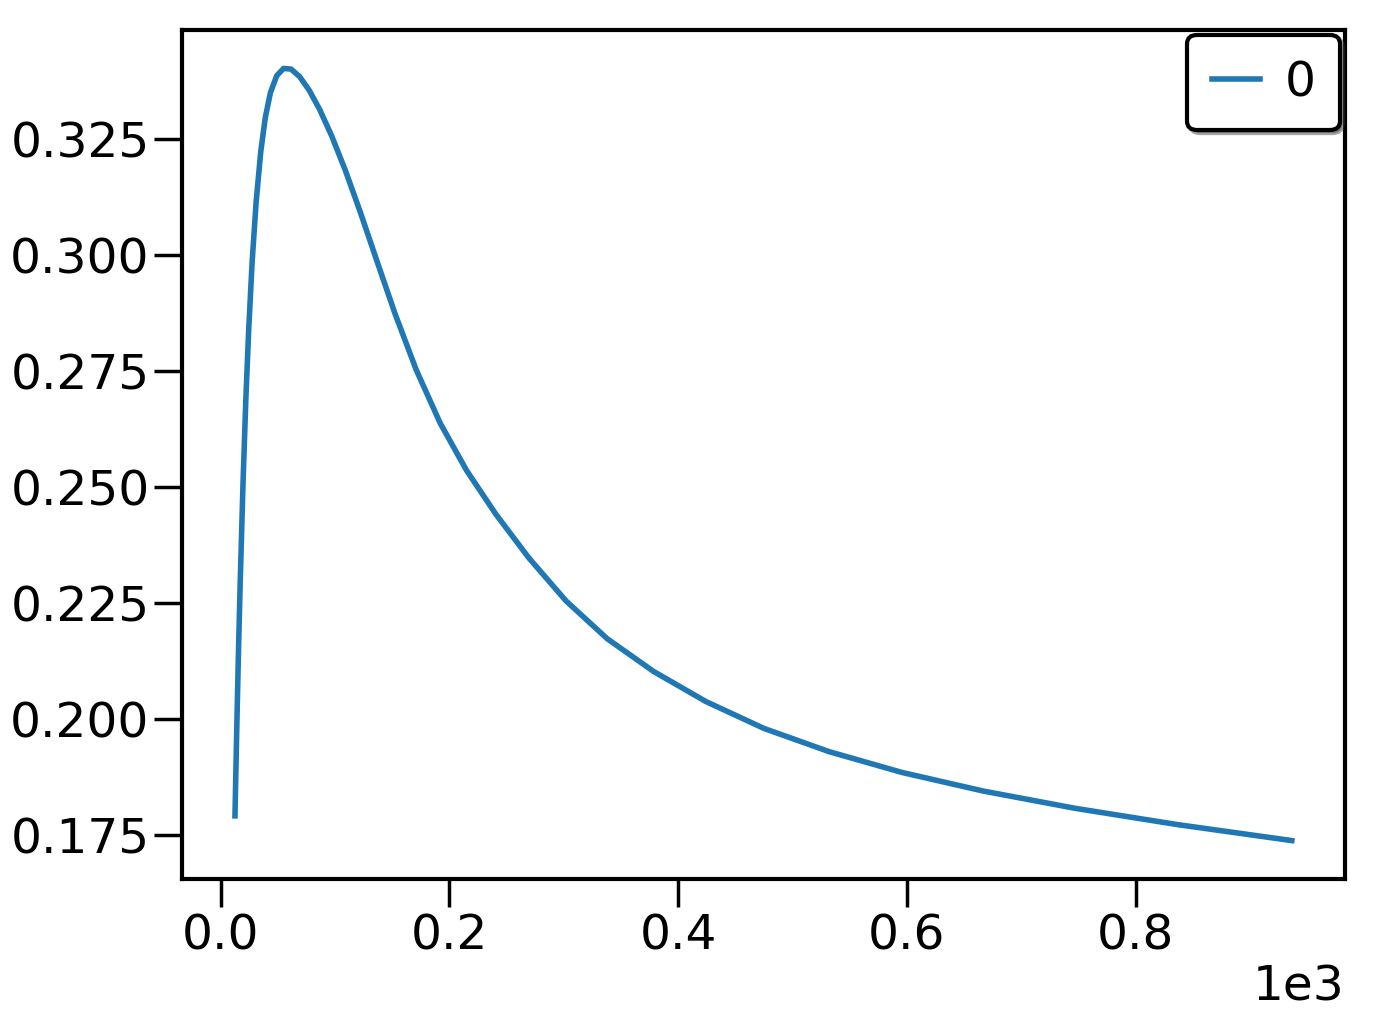

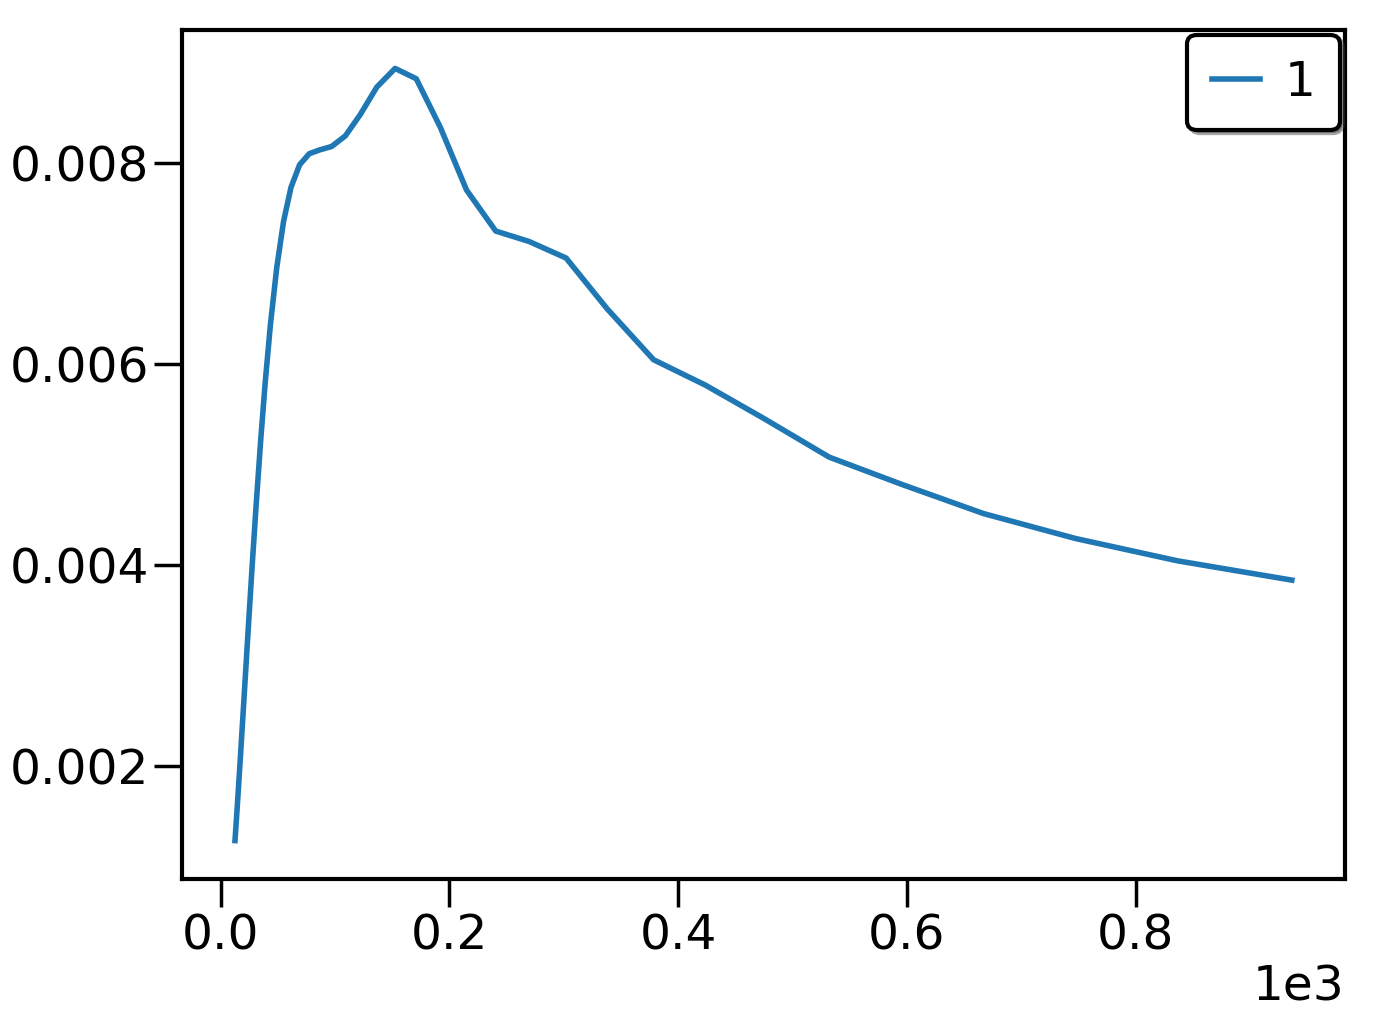

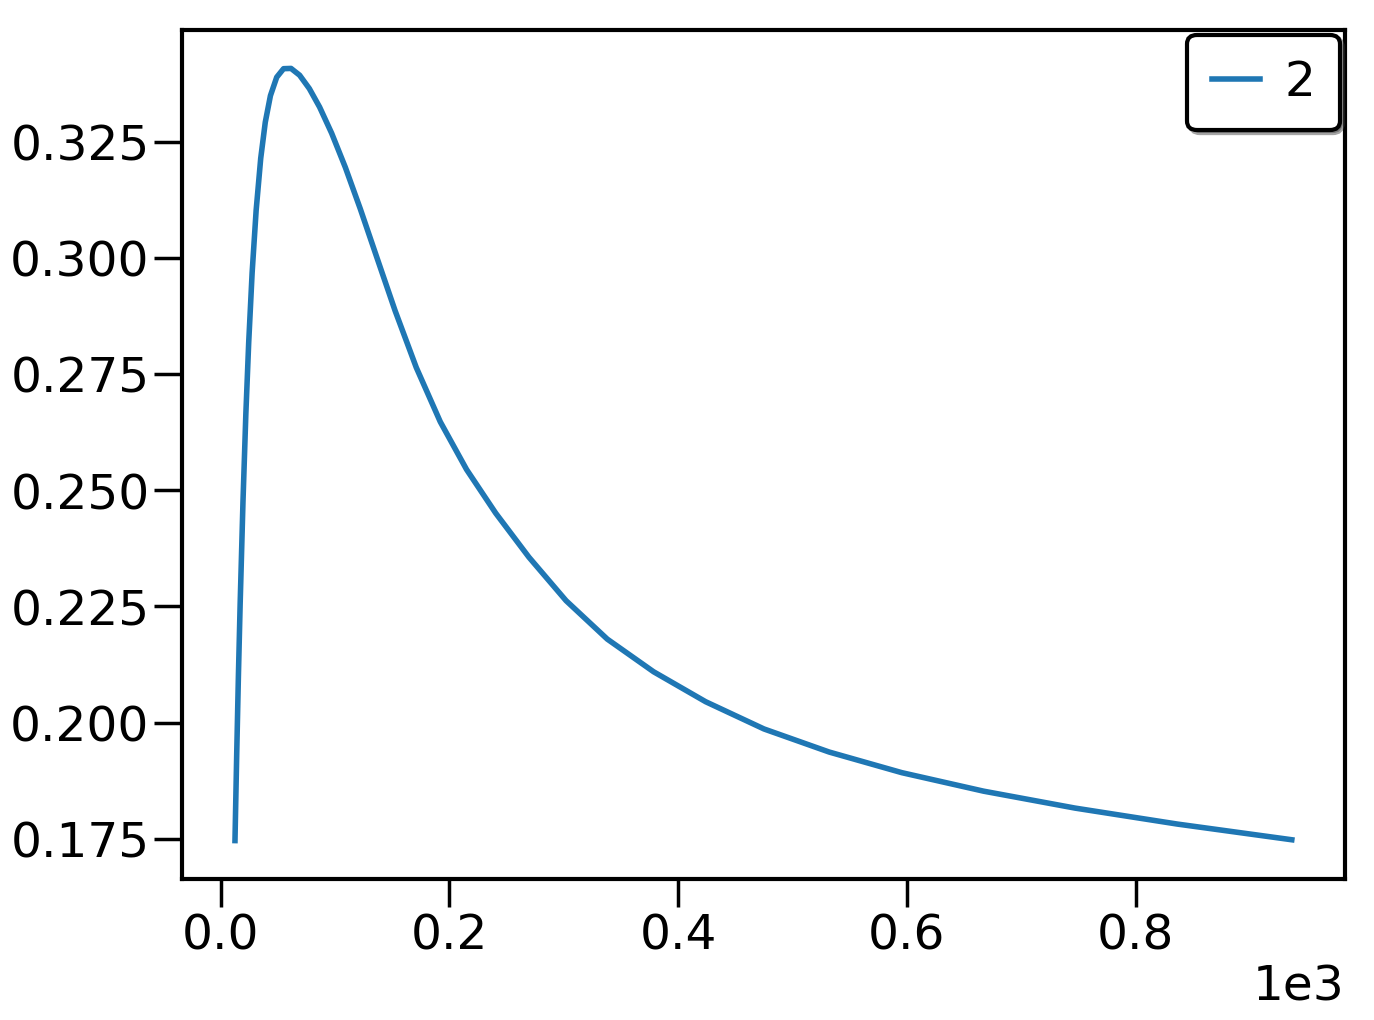

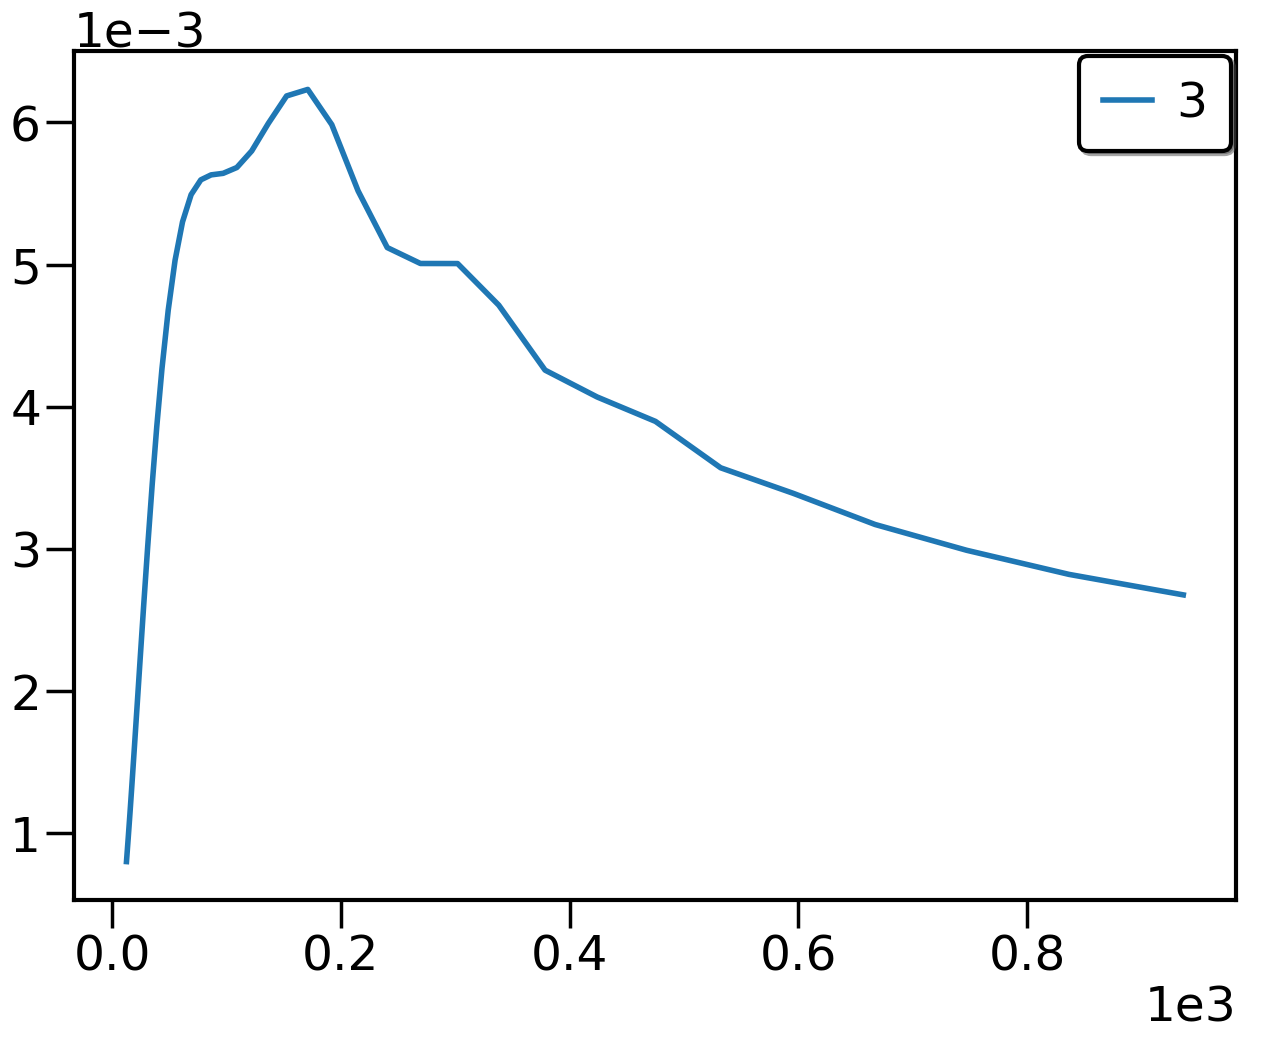

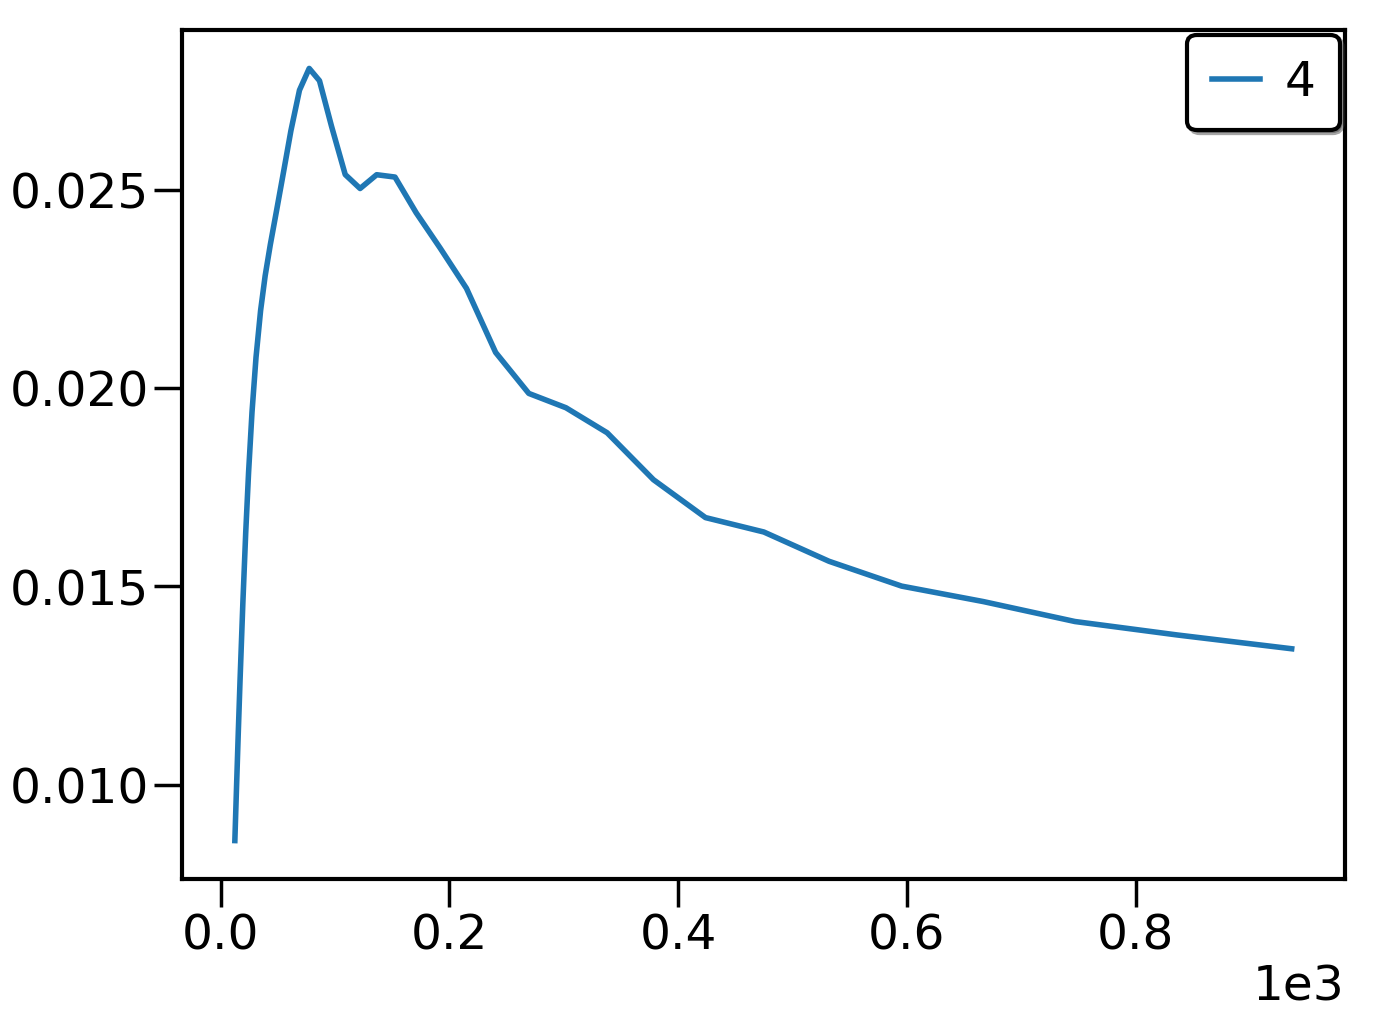

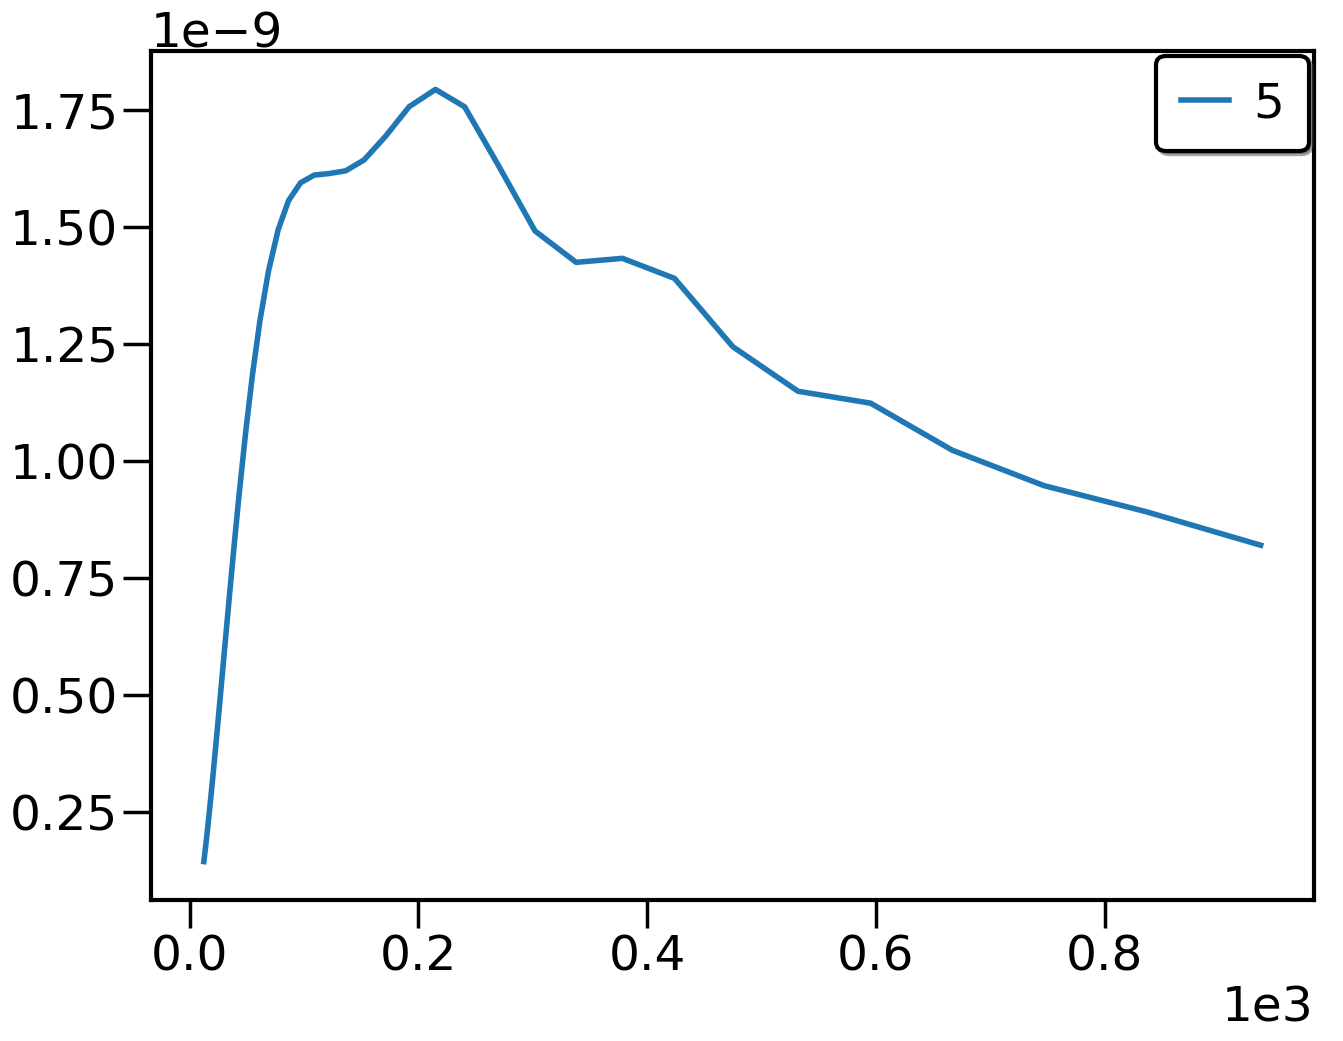

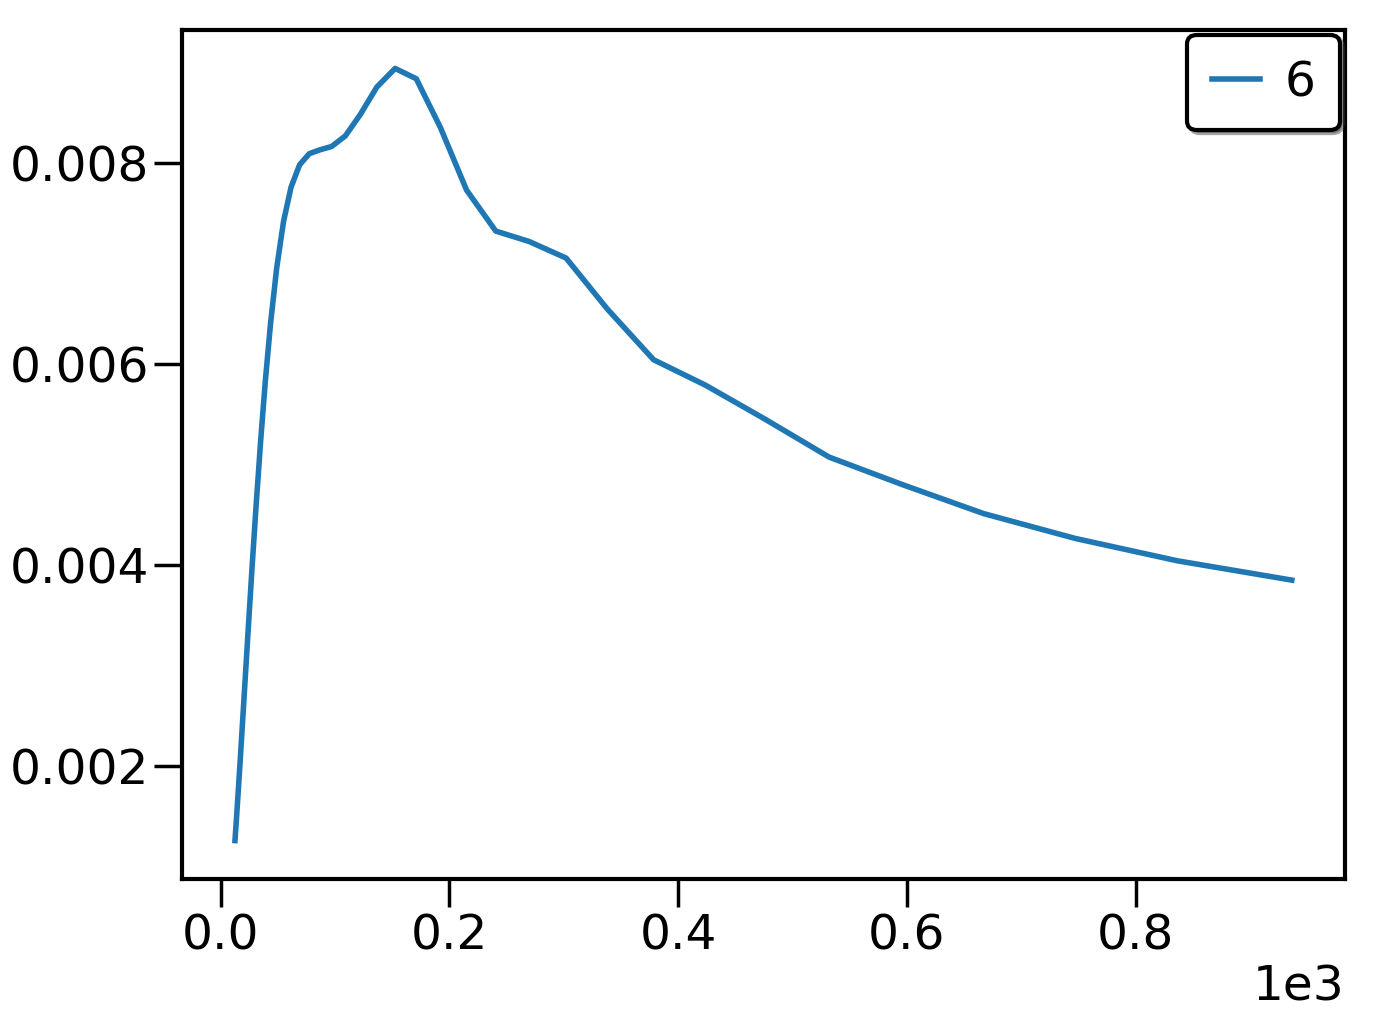

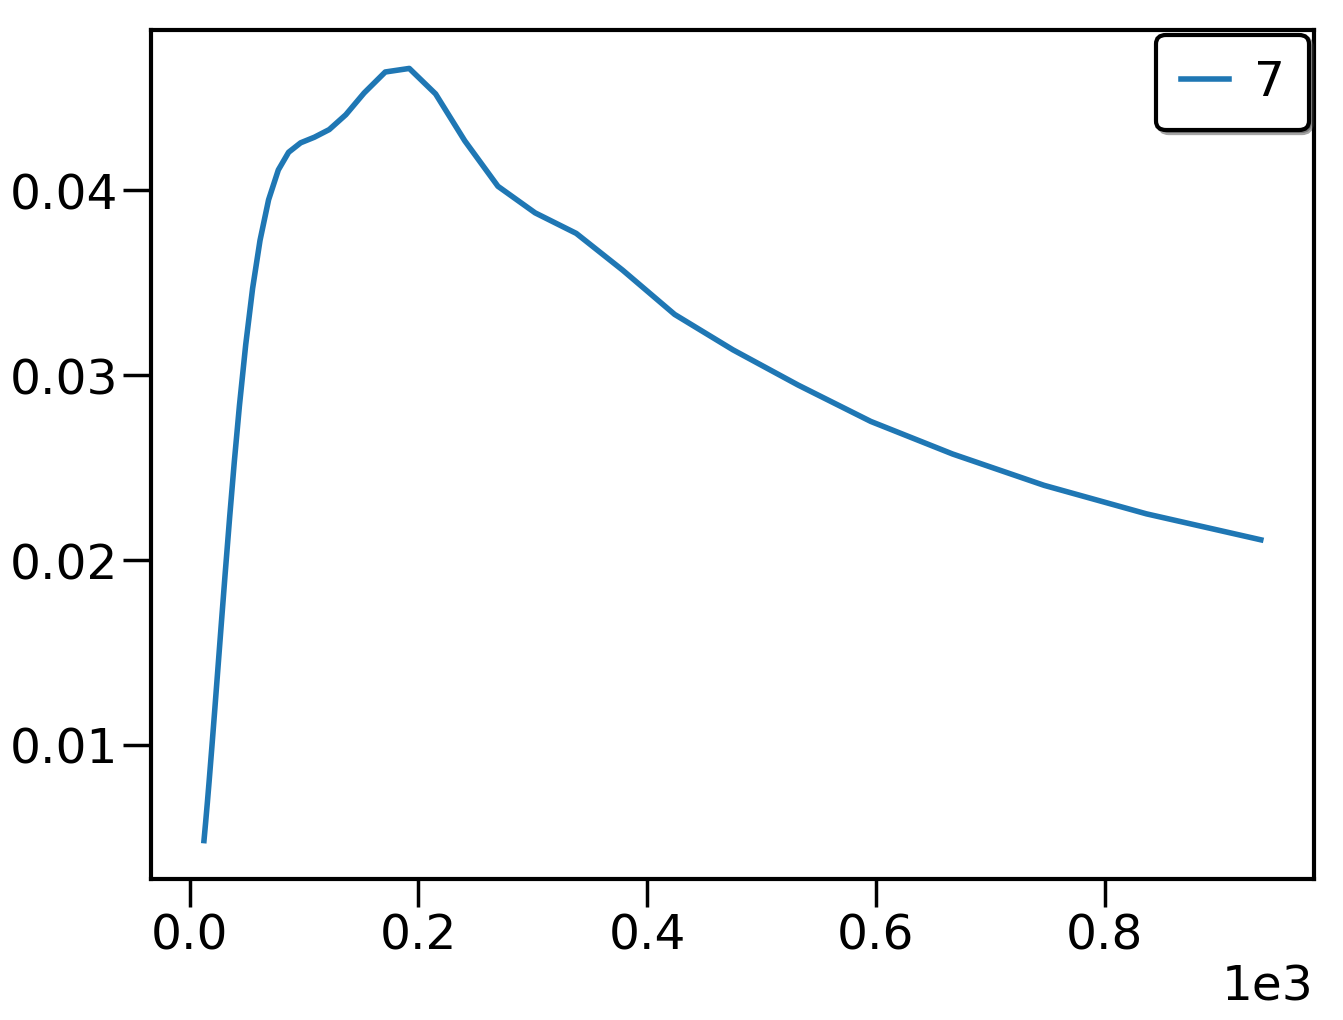

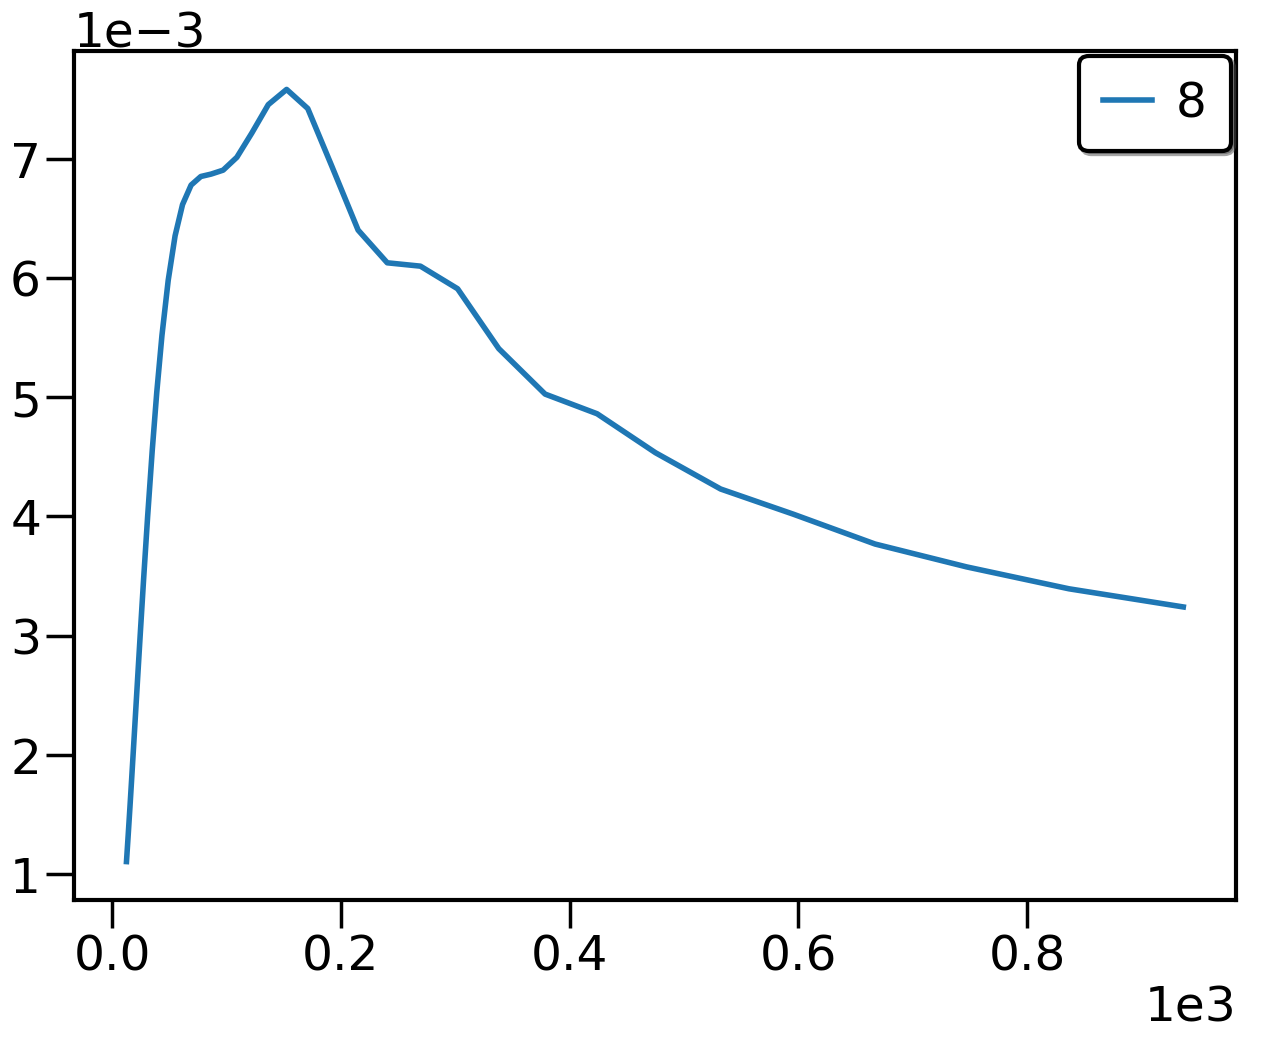

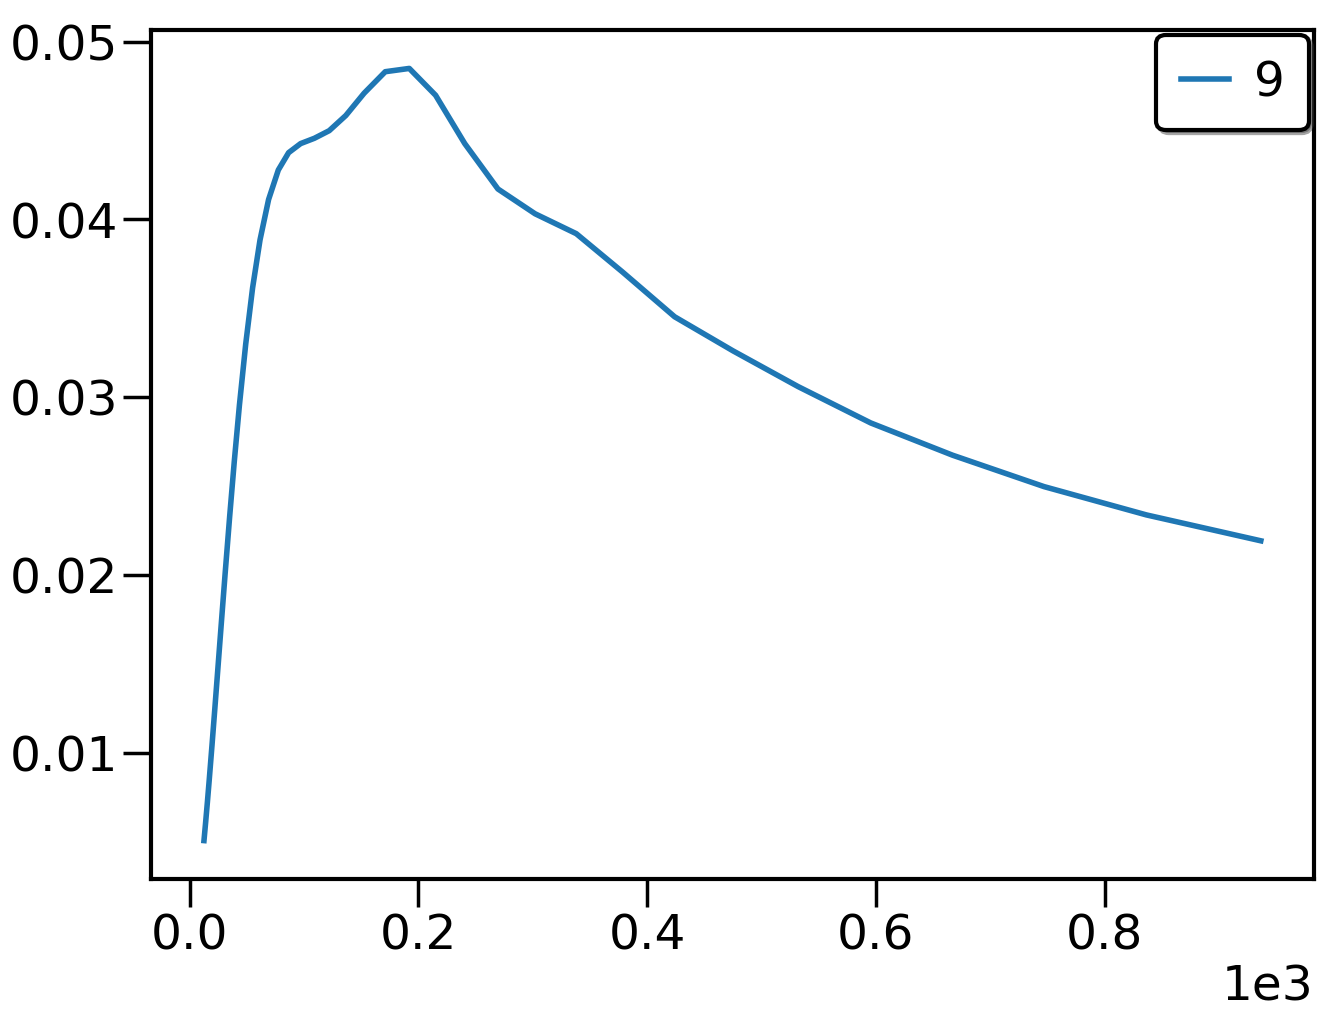

In [58]:
nt=len(lb)
for i in np.arange(10):
    plot(lb,lb*cl_L['cl_b'][i*nt:(i+1)*nt],label=i)
    legend()
    show()
# yscale('log')

In [78]:
kappa_class.z_bins['galaxy'].keys()

dict_keys([0, 1, 'n_bins', 'z_lens_kernel', 'zmax', 'zp', 'pz', 'z_bins', 'zp_sigma', 'zp_bias', 2, 3, 4, 5])

In [79]:
priors={}
priors['As']=np.inf
priors['Om']=np.inf
priors['w']=np.inf
priors['wa']=np.inf

In [80]:
priors['pz_B_s']=0.001 #bias =B*(1+z) 
priors['pz_B_l']=0.0001 #bias =B*(1+z) 
for i in np.arange(10): #photo-z bias
    priors['pz_b_s_'+str(i)]=0.001

for i in np.arange(10): #photo-z bias
    priors['pz_b_l_'+str(i)]=0.0001

for i in np.arange(10): #photo-z bias
    for j in np.arange(100): #photo-z bias
        priors['nz_s_'+str(i)+'_'+str(j)]=0.01

for i in np.arange(10): #photo-z bias
    for j in np.arange(100): #photo-z bias
        priors['nz_l_'+str(i)+'_'+str(j)]=0.01

        
for i in np.arange(10):#galaxy bias
    priors['g_b_s_1'+str(i)]=1
for i in np.arange(10): #galaxy bias, b2
    priors['g_b_s_2'+str(i)]=1

for i in np.arange(10):#galaxy bias
    priors['g_b_l_1'+str(i)]=1
for i in np.arange(10): #galaxy bias, b2
    priors['g_b_l_2'+str(i)]=1

    
for i in np.arange(10): #baryon PCA
    priors['Q'+str(i)]=100

In [81]:
z_bins_kwargs['use_window']=False

In [82]:
if use_window:
    kappa_class.Win.store_win=True

In [83]:
pz_params=['pz_b_s_{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
# pz_params+=['pz_b_l_{j}'.format(j=i) for i in np.arange(2)]
galaxy_params=[]#['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
# galaxy_params=['g_b_l_1{j}'.format(j=i) for i in np.arange(4)]

cosmo_params=np.atleast_1d(['As'])#,'Om','w','wa'])

%time f0=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
{} 6.754109144210815
shear 6.785112619400024
As [2.178e-09 2.222e-09]
cl dict done
cl dict done
pz_b_s_0 [-0.01  0.01]
ns0:  25.674672523983695
cl dict done
ns0:  25.674672523983695
cl dict done
pz_b_s_1 [-0.01  0.01]
ns0:  25.674672523983695
cl dict done
ns0:  25.674672523983695
cl dict done
CPU times: user 1min 27s, sys: 176 ms, total: 1min 27s
Wall time: 53.4 s


In [ ]:
crash

In [ ]:
pz_params=['nz_s_{j}_{k}'.format(j=i,k=k) for i in np.arange(kappa_class.z_bins['shear']['n_bins']) for k in np.arange(100)]
# pz_params+=['nz_l_{j}_8'.format(j=i) for i in np.arange(2)]
# galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
# galaxy_params=['g_b_l_1{j}'.format(j=i) for i in np.arange(4)]
galaxy_params=[]
print(pz_params)
cosmo_params=np.atleast_1d(['As'])#,'Om','w','wa'])

%time f_nz0=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)

['nz_s_0_0', 'nz_s_0_1', 'nz_s_0_2', 'nz_s_0_3', 'nz_s_0_4', 'nz_s_0_5', 'nz_s_0_6', 'nz_s_0_7', 'nz_s_0_8', 'nz_s_0_9', 'nz_s_0_10', 'nz_s_0_11', 'nz_s_0_12', 'nz_s_0_13', 'nz_s_0_14', 'nz_s_0_15', 'nz_s_0_16', 'nz_s_0_17', 'nz_s_0_18', 'nz_s_0_19', 'nz_s_0_20', 'nz_s_0_21', 'nz_s_0_22', 'nz_s_0_23', 'nz_s_0_24', 'nz_s_0_25', 'nz_s_0_26', 'nz_s_0_27', 'nz_s_0_28', 'nz_s_0_29', 'nz_s_0_30', 'nz_s_0_31', 'nz_s_0_32', 'nz_s_0_33', 'nz_s_0_34', 'nz_s_0_35', 'nz_s_0_36', 'nz_s_0_37', 'nz_s_0_38', 'nz_s_0_39', 'nz_s_0_40', 'nz_s_0_41', 'nz_s_0_42', 'nz_s_0_43', 'nz_s_0_44', 'nz_s_0_45', 'nz_s_0_46', 'nz_s_0_47', 'nz_s_0_48', 'nz_s_0_49', 'nz_s_0_50', 'nz_s_0_51', 'nz_s_0_52', 'nz_s_0_53', 'nz_s_0_54', 'nz_s_0_55', 'nz_s_0_56', 'nz_s_0_57', 'nz_s_0_58', 'nz_s_0_59', 'nz_s_0_60', 'nz_s_0_61', 'nz_s_0_62', 'nz_s_0_63', 'nz_s_0_64', 'nz_s_0_65', 'nz_s_0_66', 'nz_s_0_67', 'nz_s_0_68', 'nz_s_0_69', 'nz_s_0_70', 'nz_s_0_71', 'nz_s_0_72', 'nz_s_0_73', 'nz_s_0_74', 'nz_s_0_75', 'nz_s_0_76', 'nz_s_0_

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
{} 5.438544511795044
shear 5.452512741088867
As [2.178e-09 2.222e-09]
cl dict done
cl dict done
0 0
nz_s_0_0 [0.06035592 0.06157523]
cl dict done
cl dict done
0 1
nz_s_0_1 [0.06038168 0.06160151]
cl dict done
cl dict done
0 2
nz_s_0_2 [0.06041034 0.06163075]
cl dict done
cl dict done
0 3
nz_s_0_3 [0.06044225 0.0616633 ]
cl dict done
cl dict done
0 4
nz_s_0_4 [0.06047776 0.06169953]
cl dict done
cl dict done
0 5
nz_s_0_5 [0.06051728 0.06173985]
cl dict done
cl dict done
0 6
nz_s_0_6 [0.06056127 0.06178473]
cl dict done
cl dict done
0 7
nz_s_0_7 [0.06061022 0.06183467]
cl dict done
cl dict done
0 8
nz_s_0_8 [0.06066471 0.06189026]
cl dict done
cl dict done
0 9
nz_s_0_9 [0.06072535 0.06195213]
cl dict done
cl dict done
0 10
nz_s_0_10 [0.06079284 0.06202098]
cl dict done
cl dict done
0 11
nz_s_0_11 [0.06086796 0.06209762]
cl dict done
cl dict done
0 12
nz_s_0_12 [0.06095157 0.06218291]
cl dict done
cl dict done
0 13
nz_s_0_13 [0.06104462 0.06227784]
cl dict done
cl dict done
0

cl dict done
cl dict done
1 32
nz_s_1_32 [-0.01  0.01]
cl dict done
cl dict done
1 33
nz_s_1_33 [-0.01  0.01]
cl dict done
cl dict done
1 34
nz_s_1_34 [-0.01  0.01]
cl dict done
cl dict done
1 35
nz_s_1_35 [-0.01  0.01]
cl dict done
cl dict done
1 36
nz_s_1_36 [-0.01  0.01]
cl dict done
cl dict done
1 37
nz_s_1_37 [-0.01  0.01]
cl dict done
cl dict done
1 38
nz_s_1_38 [-0.01  0.01]
cl dict done
cl dict done
1 39
nz_s_1_39 [-0.01  0.01]
cl dict done
cl dict done
1 40
nz_s_1_40 [-0.01  0.01]
cl dict done
cl dict done
1 41
nz_s_1_41 [-0.01  0.01]
cl dict done
cl dict done
1 42
nz_s_1_42 [-0.01  0.01]
cl dict done
cl dict done
1 43
nz_s_1_43 [-0.01  0.01]
cl dict done
cl dict done
1 44
nz_s_1_44 [-0.01  0.01]
cl dict done
cl dict done
1 45
nz_s_1_45 [-0.01  0.01]
cl dict done
cl dict done
1 46
nz_s_1_46 [-0.01  0.01]
cl dict done
cl dict done
1 47
nz_s_1_47 [-0.01  0.01]
cl dict done
cl dict done
1 48
nz_s_1_48 [-0.01  0.01]
cl dict done
cl dict done
1 49
nz_s_1_49 [-0.01  0.01]
cl dict do

In [91]:
f0['error'],f0['prior']['error']

(array([2.81960785e-12, 1.64177079e-04, 5.37691686e-04]),
 array([2.80493178e-12, 1.61908169e-04, 4.73546839e-04]))

In [94]:
f_nz0['error'],f_nz0['prior']['error']

(array([2.04071283e-12, 4.42966681e+08, 4.58947531e+08, 4.15993489e+08,
        4.14396073e+08, 6.39501988e+03, 2.78906021e+03, 3.50808360e+03,
        4.05957764e+03, 1.02085249e+03, 3.87717172e+02, 2.39130388e+02,
        4.58389234e+02, 1.32858522e+03, 3.66787510e+03, 1.03997719e+04,
        3.70500247e+04, 8.32754312e+04, 1.03330323e+05, 1.13797101e+05,
        1.21800065e+05, 8.50010002e+04, 3.99218696e+04, 1.87429559e+04,
        6.99044626e+03, 1.27449083e+03, 2.03177387e+02, 2.52286786e+01,
        1.22018180e+01, 1.15949483e+01, 1.41161773e+01, 3.82499865e+01,
        1.26374726e+02, 3.16329136e+02, 5.93559185e+02, 9.09678317e+02,
        1.16265223e+03, 1.20963018e+03, 9.80563859e+02, 6.30553845e+02,
        3.34772307e+02, 1.41024114e+02, 4.77469294e+01, 1.25323418e+01,
        6.52843870e+00, 2.04450134e+04, 6.37479781e+04, 6.60209618e+04,
        2.94434517e+04, 3.17596711e+04, 1.09737317e+04, 8.60759037e+03,
        6.46746348e+03, 3.93779352e+03, 1.26272367e+03, 7.074664

In [ ]:
pz_params=['pz_b_s_{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
pz_params+=['pz_b_l_{j}'.format(j=i) for i in np.arange(2)]
galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
galaxy_params+=['g_b_l_1{j}'.format(j=i) for i in np.arange(4)]

cosmo_params=np.atleast_1d(['As','Om','w','wa'])

%time f_all=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
{} 5.304181337356567
shear 5.3177809715271
As [2.178e-09 2.222e-09]


In [ ]:
pz_params=['nz_s_{j}_{k}'.format(j=i,k=k) for i in np.arange(kappa_class.z_bins['shear']['n_bins']) for k in np.arange(100)]
pz_params+=['nz_l_{j}_8'.format(j=i) for i in np.arange(2)]
galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
galaxy_params+=['g_b_l_1{j}'.format(j=i) for i in np.arange(4)]
# galaxy_params=[]
# print(pz_params)
cosmo_params=np.atleast_1d(['As','Om','w','wa'])

%time f_nz_all=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)

In [ ]:
f_all['error'],f_all['prior']['error']

In [ ]:
f_nz_all['error'][:4],f_nz_all['prior']['error'][:4]

In [ ]:
f_nz_all['error'][:4]/f_all['error'][:4]

In [ ]:
f_nz_all['prior']['error'][:4]/f_all['prior']['error'][:4]

In [ ]:
f['error'][0]/f0['error'][0],f['prior']['error'][0]/f0['prior']['error'][0]